In [1]:
catName = 'high'

In [2]:
import sys, os, pickle, time, re
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')

In [3]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from array import array

import ROOT as rt
rt.TGaxis.SetMaxDigits(4)
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import ROOT.RooFit as rf
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff
from histo_utilities import create_TH1D, create_TH2D, SetMaxToMaxHist
from gridVarQ2Plot import col_dic, label_dic
from progressBar import ProgressBar
from categoriesDef import categories
cat = categories[catName]

from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1


CMS_lumi.extraText = 7*' ' + 'Internal'

donotdelete = []

Welcome to JupyROOT 6.12/07


In [4]:
m_mu = 0.1056583755
m_pi = 0.13957062
m_K = 0.493677
m_D0 = 1.86483
m_Dst = 2.01026
m_jpsi = 3.096916
dm = m_Dst - m_D0

In [5]:
(m_Dst**2 - m_D0**2 - m_pi**2)/m_Dst**2

0.13463371017492218

In [6]:
(m_D0**2 - m_pi**2 - m_K**2)/m_D0**2

0.9243163029587738

In [7]:
E_D0 = (m_Dst**2 - m_pi**2 + m_D0**2)/(2*m_Dst)
pst = np.sqrt(E_D0**2 - m_D0**2)
print pst

0.039361027202524865


In [8]:
catText = rt.TLatex()
catText.SetTextAlign(31)
catText.SetTextSize(0.06)
catText.SetTextFont(42)
catText.SetTextSize(0.05)

In [9]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [10]:
df = pd.DataFrame(rtnp.root2array('../data/cmsRD/skimmed/B2DstMu_200327_{}.root'.format(cat.name)))

In [11]:
loc = '../data/cmsMC_private/'
loc += 'BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/'
loc += 'ntuples_B2DstMu/skimmed/{}.root'.format(cat.name)
df_MC = pd.DataFrame(rtnp.root2array(loc))

In [12]:
'  '.join(df.columns)

'index  q2  Est_mu  M2_miss  mu_pt  mu_eta  mu_phi  mu_sigdxy  B_pt  B_eta  B_phi  Dst_pt  Dst_eta  Dst_phi  D0_pt  D0_eta  D0_phi  pi_pt  pi_eta  pi_phi  pi_IP  K_pt  K_eta  K_phi  K_IP  pval_piK  sigdxy_vtxD0_PV  pis_pt  pis_eta  pis_phi  pis_IP  pval_D0pis  mass_piK  mass_D0pis  mass_D0pismu  pval_D0pismu  cos_D0pismu_PV  cosT_D0pismu_PV  N_lowMassAddTks  tkMassHad_0  tkMassHad_1  tkMassMuTk_0  tkMassMuTk_1  tkMassVis_0  tkMassVis_1  tkPt_0  tkPt_1  cat_low  cat_mid  cat_high  N_vtx'

In [13]:
dataDir = '../data/cmsRD'
datasets_loc = glob(dataDir + '/ParkingBPH*/*2018*B2DstMu_200327*')
lumi_tot = getLumiByTrigger(datasets_loc, cat.trg, verbose=True)
CMS_lumi.integrated_lumi = lumi_tot

Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200327
HLT_Mu12_IP6_part2_v2 5.29
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200327
HLT_Mu12_IP6_part1_v2 5.13
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200327
HLT_Mu12_IP6_part4_v2 5.29
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200327
HLT_Mu12_IP6_part3_v2 5.29
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200327
HLT_Mu12_IP6_part0_v2 5.25
Total lumi: 26.25 fb^-1


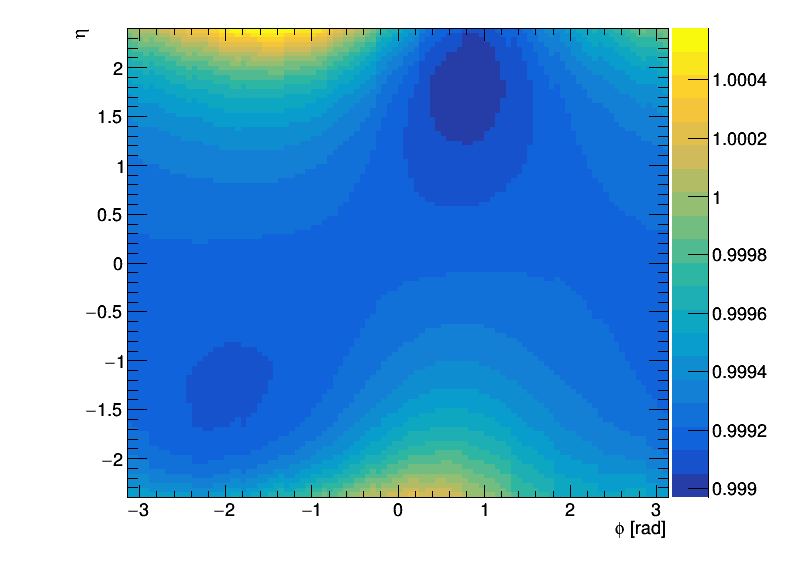

In [60]:
fBfield = rt.TFile.Open('../data/calibration/bFieldMap_2Dover3D.root', 'r')
hBfield = fBfield.Get('bfieldMap')
def get_bFieldCorr3D(phi, eta, verbose=False):
    if not verbose:
        idx = hBfield.GetBin(hBfield.GetXaxis().FindBin(phi), hBfield.GetYaxis().FindBin(eta))
        return 1./hBfield.GetBinContent(idx)
hBfield.SetXTitle('#phi [rad]')
hBfield.SetYTitle('#eta')
c = rt.TCanvas('c', 'c', 800, 600)
c.SetRightMargin(0.16)
hBfield.Draw('colz')
c.Draw()

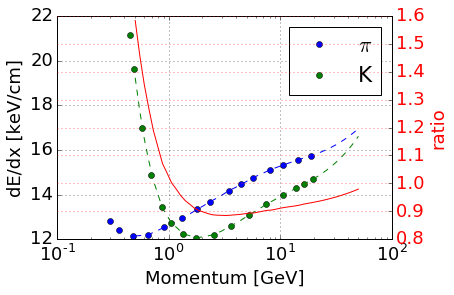

In [87]:
interp1d
points_dedxPi = np.loadtxt('../data/calibration/dEdx_correction/dEdx_vs_P_pion.txt', delimiter=',')
dedx_pi = interp1d(points_dedxPi[:,0], points_dedxPi[:,1], kind='linear', fill_value='extrapolate')

points_dedxK = np.loadtxt('../data/calibration/dEdx_correction/dEdx_vs_P_Kaon.txt', delimiter=',')
dedx_K = interp1d(points_dedxK[:,0], points_dedxK[:,1], kind='linear', fill_value='extrapolate')

fig, ax1 = plt.subplots()

x = np.logspace(np.log10(0.5), np.log10(50), 50)
plt.plot(points_dedxPi[:,0], points_dedxPi[:,1], 'bo', label=r'$\pi$')
plt.plot(x, dedx_pi(x), 'b--')
plt.plot(points_dedxK[:,0], points_dedxK[:,1], 'go', label='K')
plt.plot(x, dedx_K(x), 'g--')

plt.legend(loc='best', numpoints=1)
plt.xlabel('Momentum [GeV]')
plt.ylabel('dE/dx [keV/cm]')
plt.xscale('log')
plt.grid()

def dEdx_ratio(P):
    return dedx_K(P)/dedx_pi(P)

ax2 = ax1.twinx()
color = 'r'
ax2.set_ylabel('ratio', color=color)
ax2.plot(x, dEdx_ratio(x), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(axis='y', color=color)

In [124]:
def varMass(dset, sp1='pi', sp2='K', m1=m_pi, m2=m_K, scalePt=1., shiftE=[0,0], relSmear=0, applyBmap=False):
    c1 = np.ones_like(dset[sp1+'_eta'])
    c2 = np.ones_like(dset[sp2+'_eta'])
    if applyBmap:
        for i, (phi, eta) in enumerate(zip(dset[sp1+'_phi'], dset[sp1+'_eta'])):
            c1[i] = get_bFieldCorr3D(phi, eta)
        print 'Average magnetic field correction: {:1.1e}'.format(np.mean(c1)-1)
        for i, (phi, eta) in enumerate(zip(dset[sp2+'_phi'], dset[sp2+'_eta'])):
            c2[i] = get_bFieldCorr3D(phi, eta)
        
    if relSmear:
        sm1 = relSmear[0]*np.random.randn(dset[sp1+'_pt'].shape[0]) + 1.
        sm2 = relSmear[1]*np.random.randn(dset[sp2+'_pt'].shape[0]) + 1.
    else:
        sm1 = 1.
        sm2 = 1.
    E1 = np.hypot(m1, scalePt * c1 *dset[sp1+'_pt'] * sm1 * np.cosh(dset[sp1+'_eta'])) + shiftE[0]
    E2 = np.hypot(m2, scalePt * c2 *dset[sp2+'_pt'] * sm2 * np.cosh(dset[sp2+'_eta'])) + shiftE[1]
    pt1 = np.sqrt(np.square(E1) - np.square(m1))/np.cosh(dset[sp1+'_eta'])
    pt2 = np.sqrt(np.square(E2) - np.square(m2))/np.cosh(dset[sp2+'_eta'])
    p1p2 = pt1*pt2
    p1p2 *= np.cos(dset[sp1+'_phi'] - dset[sp2+'_phi']) + np.sinh(dset[sp1+'_eta'])*np.sinh(dset[sp2+'_eta'])
    
    M = np.square(m1) + np.square(m2) + 2*(E1*E2 - p1p2)
    return np.sqrt(M)

In [168]:
def varMass_3(dset, sp1='pi', sp2='K', sp3='pis',
              m1=m_pi, m2=m_K, m3=m_pi,
              scalePt=1., 
              shiftE=[0,0,0], 
              relSmear=0,
              applyBmap=False,
              returnM12=False
             ):
    
    c1 = np.ones_like(dset[sp1+'_eta'])
    c2 = np.ones_like(dset[sp2+'_eta'])
    c3 = np.ones_like(dset[sp2+'_eta'])
    if applyBmap:
        for i, (phi, eta) in enumerate(zip(dset[sp1+'_phi'], dset[sp1+'_eta'])):
            c1[i] = get_bFieldCorr3D(phi, eta)
        print 'Average magnetic field correction: {:1.1e}'.format(np.mean(c1)-1)
        for i, (phi, eta) in enumerate(zip(dset[sp2+'_phi'], dset[sp2+'_eta'])):
            c2[i] = get_bFieldCorr3D(phi, eta)
        for i, (phi, eta) in enumerate(zip(dset[sp3+'_phi'], dset[sp3+'_eta'])):
            c3[i] = get_bFieldCorr3D(phi, eta)
        
    if relSmear:
        sm1 = relSmear[0]*np.random.randn(dset[sp1+'_pt'].shape[0]) + 1.
        sm2 = relSmear[1]*np.random.randn(dset[sp2+'_pt'].shape[0]) + 1.
        sm3 = relSmear[2]*np.random.randn(dset[sp3+'_pt'].shape[0]) + 1.
    else:
        sm1 = 1.
        sm2 = 1.
        sm3 = 1.
        
    E1 = np.hypot(m1, scalePt * c1 * dset[sp1+'_pt'] * sm1 * np.cosh(dset[sp1+'_eta'])) + shiftE[0]
    E2 = np.hypot(m2, scalePt * c2 * dset[sp2+'_pt'] * sm2 * np.cosh(dset[sp2+'_eta'])) + shiftE[1]
    E3 = np.hypot(m3, scalePt * c3 * dset[sp3+'_pt'] * sm3 * np.cosh(dset[sp3+'_eta'])) + shiftE[2]
    
    pt1 = np.sqrt(np.square(E1) - m1**2)/np.cosh(dset[sp1+'_eta'])
    pt2 = np.sqrt(np.square(E2) - m2**2)/np.cosh(dset[sp2+'_eta'])
    pt3 = np.sqrt(np.square(E3) - m3**2)/np.cosh(dset[sp3+'_eta'])
    
    p1p2 = pt1*pt2
    p1p2 *= np.cos(dset[sp1+'_phi'] - dset[sp2+'_phi']) + np.sinh(dset[sp1+'_eta'])*np.sinh(dset[sp2+'_eta'])
    
    p1p3 = pt1*pt3
    p1p3 *= np.cos(dset[sp1+'_phi'] - dset[sp3+'_phi']) + np.sinh(dset[sp1+'_eta'])*np.sinh(dset[sp3+'_eta'])
    
    p2p3 = pt2*pt3
    p2p3 *= np.cos(dset[sp2+'_phi'] - dset[sp3+'_phi']) + np.sinh(dset[sp2+'_eta'])*np.sinh(dset[sp3+'_eta'])
    
    M = np.square(m1) + np.square(m2) + np.square(m3) + 2*(E1*E2 - p1p2) + 2*(E1*E3 - p1p3) + 2*(E2*E3 - p2p3)
    
    if returnM12:
        m12 = np.square(m1) + np.square(m2) + 2*(E1*E2 - p1p2)
        return np.sqrt(M), np.sqrt(m12)
    else:
        return np.sqrt(M)

In [18]:
def getAvg(mass):
    m = np.mean(mass)
    s = np.std(mass)
    return [m, s/np.sqrt(mass.shape[0])]

In [19]:
from scipy.stats import chi2 as DistChi2
def fitLineFor0(x, y, yerr=1):
    #Fitting y = mx
    m = np.sum(x*y/np.square(yerr))/np.sum(np.square(x/yerr))
    dm = 1./np.sum(np.square(x/yerr))
    
    S = np.sum(np.square((y-m*x)/yerr))
    ndof = x.shape[0] - 1
    pval = 1 - DistChi2.cdf(S, ndof)
    return m, dm, pval

# General plots

In [20]:
def drawVar(varRD, varMC,
            varRDcorr=None, varMCcorr=None,
            binning=None, xtitle='', legLoc=[0.18, 0.7, 0.4, 0.93], opt='overflow+underflow'):
    leg = rt.TLegend(legLoc[0], legLoc[1], legLoc[2], legLoc[3])
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)
    
    hRD = create_TH1D(varRD, 'RDbare',
                      binning=binning, 
                      axis_title=[xtitle, 'Normalized candidates'],
                      scale_histo='norm',
                      opt=opt
                     )
    leg.AddEntry(hRD, 'data', 'lep')

    hMC = create_TH1D(varMC, 'MCbare', binning=hRD.binning, opt=opt, scale_histo='norm')
    hMC.SetLineColor(col_dic['mu'])
    leg.AddEntry(hMC, label_dic['mu'], 'lep')
    h_list = [hRD, hMC]
    
    if not varRDcorr is None:
        hRDc = create_TH1D(varRDcorr, 'RDcorr', binning=hRD.binning, scale_histo='norm', opt=opt)
        hRDc.SetLineColor(1)
        hRD.SetLineColor(rt.kGray)
        h_list.append(hRDc)
        leg.AddEntry(hRDc, 'data corr', 'lep')
        
    if not varMCcorr is None:
        hMCc = create_TH1D(varMCcorr, 'MCcorr', binning=hRD.binning, scale_histo='norm', opt=opt)
        hMCc.SetLineColor(col_dic['mu'])
        hMC.SetLineColor(col_dic['mu']-10)
        h_list.append(hMCc)
        leg.AddEntry(hMCc, label_dic['mu']+' corr', 'lep')
        
    
    SetMaxToMaxHist(h_list)
    c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
    leg.Draw()
    catText.DrawLatexNDC(0.95, 0.85, 'Category: {}'.format(cat.name))
    c.dnd = h_list + [leg]
    return c

In [21]:
def draw_dM_vs_x(m_piK_corrRD, xRD, xMC, bins, xlabel):
    avgRD = []
    avgRDcorr = []
    avgMC = []

    for i in range(len(bins)-1):
        m = bins[i]
        M = bins[i+1]   
        selRD = np.logical_and(xRD>m, xRD<M)
        avgRD.append(getAvg(df['mass_piK'][selRD]))
        if not m_piK_corrRD is None:
            avgRDcorr.append(getAvg(m_piK_corrRD[selRD]))

        selMC = np.logical_and(xMC>m, xMC<M)
        avgMC.append(getAvg(df_MC['mass_piK'][selMC]))

    avgRD = 1e3*np.array(avgRD)
    avgRDcorr = 1e3*np.array(avgRDcorr)
    avgMC = 1e3*np.array(avgMC)

    x = (bins[1:] + bins[:-1])/2.
    dx = (bins[1:] - bins[:-1])/2.

    plt.rcParams.update({'font.size': 18})
    f = plt.figure(figsize=(8,6))
    plt.errorbar(x, avgRD[:,0]-1e3*m_D0, yerr=avgRD[:,1], xerr=dx, fmt='.', label='RD')
    if not m_piK_corrRD is None:
        plt.errorbar(x, avgRDcorr[:,0]-1e3*m_D0, yerr=avgRDcorr[:,1], xerr=dx, fmt='.', label='RD corr')
    plt.errorbar(x, avgMC[:,0]-1e3*m_D0, yerr=avgMC[:,1], xerr=dx, fmt='.', label='MC')
    plt.xlabel(xlabel)
    plt.ylabel('<m($\pi$K) - m$_{D_0}$> [MeV]')
    plt.legend(loc='best', numpoints=1)
    plt.grid()

# Magnetic field 3D map

In [125]:
mCorrBfield = varMass(df, sp1='pi', sp2='K', m1=m_pi, m2=m_K, scalePt=1, shiftE=[0,0], applyBmap=True)

Average magnetic field correction: 7.9e-04


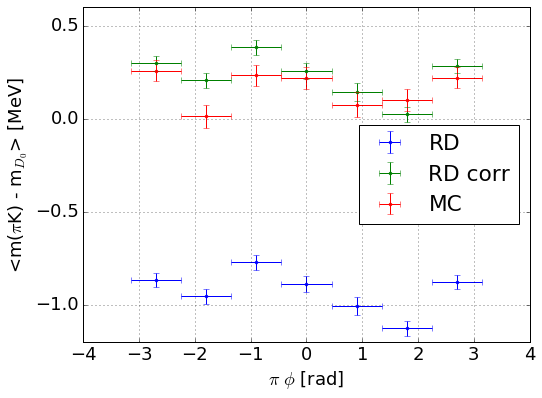

In [25]:
draw_dM_vs_x(mCorrBfield, df['pi_phi'], df_MC['pi_phi'], np.linspace(-np.pi, np.pi, 8), r'$\pi\ \phi$ [rad]')

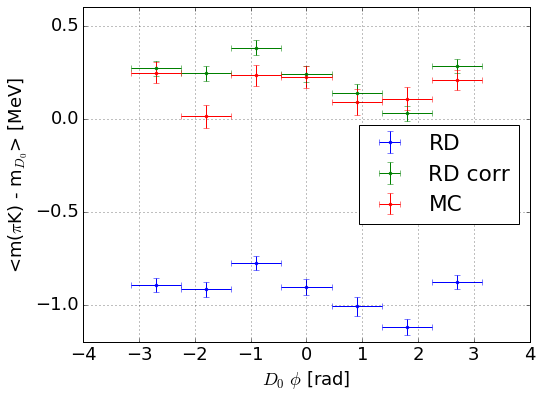

In [26]:
draw_dM_vs_x(mCorrBfield, df['D0_phi'], df_MC['D0_phi'], np.linspace(-np.pi, np.pi, 8), r'$D_0\ \phi$ [rad]')

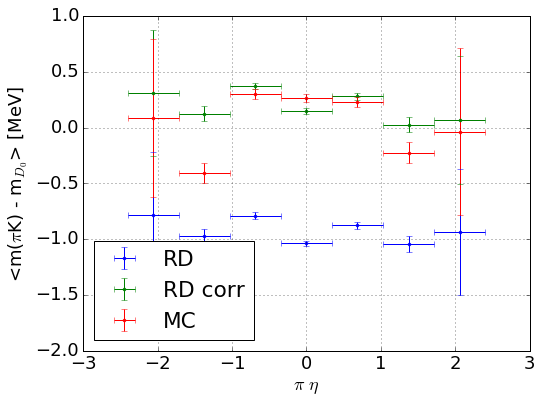

In [27]:
draw_dM_vs_x(mCorrBfield, df['pi_eta'], df_MC['pi_eta'], np.linspace(-2.4, 2.4, 8), r'$\pi\ \eta$')

# Magnetic field effect

In [28]:
def compute_mR(dset, sp1='pi', sp2='K', m1=m_pi, m2=m_K, M=m_D0, scalePt=1., shiftE=[0,0], relSmear=0):
    if relSmear:
        sm1 = relSmear*np.random.randn(dset[sp1+'_pt'].shape[0]) + 1.
        sm2 = relSmear*np.random.randn(dset[sp2+'_pt'].shape[0]) + 1.
    else:
        sm1 = 1.
        sm2 = 1.
    E1 = np.hypot(m1, scalePt * dset[sp1+'_pt'] * sm1 * np.cosh(dset[sp1+'_eta'])) + shiftE[0]
    E2 = np.hypot(m2, scalePt * dset[sp2+'_pt'] * sm2 * np.cosh(dset[sp2+'_eta'])) + shiftE[1]
    mR = np.square(m1)*E2/E1
    mR += np.square(m2)*E1/E2
    mR /= M
    return mR

qR = 1.72


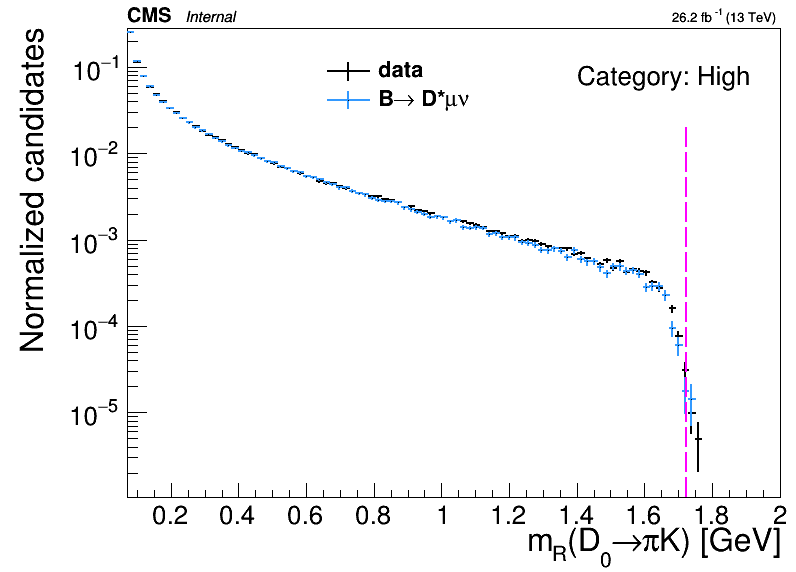

In [29]:
q2 = m_D0**2 - m_pi**2 - m_K**2
qR = q2/m_D0
print 'qR = {:.2f}'.format(qR)

xMC = compute_mR(df_MC, shiftE=[0, 1e-3])

xRD = compute_mR(df, shiftE=[0, 1e-3])

C = drawVar(xRD, xMC, binning=[100, 0.07, 2], 
            xtitle='m_{R}(D_{0}#rightarrow#piK) [GeV]', legLoc=[0.4, 0.8, 0.7, 0.9])
cl.DrawLine(qR, 0, qR, 0.02)
C.SetLogy()

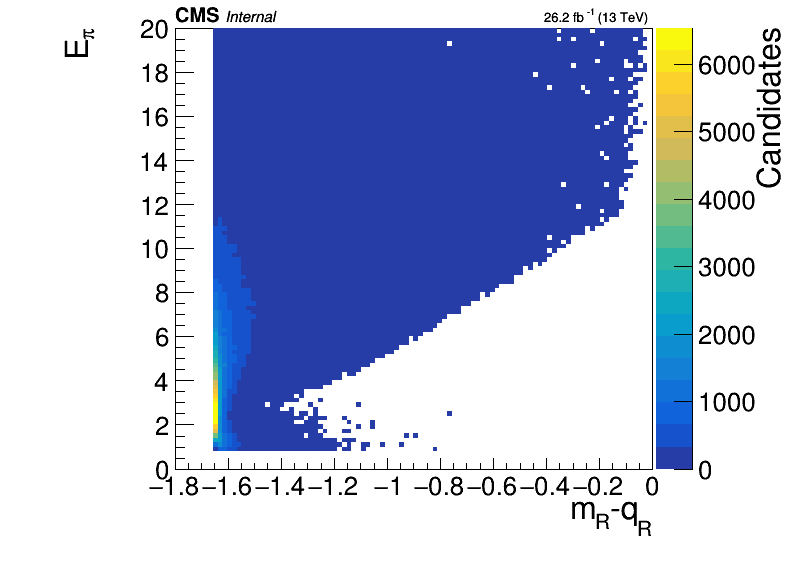

In [30]:
aux = np.column_stack((df['K_pt']*np.cosh(df['K_eta'])/m_K, df['pi_pt']*np.cosh(df['pi_eta'])/m_pi))
minBG = np.min(aux, axis=1)

E_K = np.hypot(m_K, df['K_pt']*np.cosh(df['K_eta']))
E_pi = np.hypot(m_pi, df['pi_pt']*np.cosh(df['pi_eta']))

q2 = m_D0**2 - m_pi**2 - m_K**2
qR = q2/m_D0
xRD = compute_mR(df, shiftE=[0, 1e-3])
x = np.column_stack((xRD-qR, E_pi))
h2 = create_TH2D(x, name='h_pt',
                 binning=[100,-1.8,0,100,0,20],
                 axis_title=['m_{R}-q_{R}', 'E_{#pi}', 'Candidates']
                )
CC = drawOnCMSCanvas(CMS_lumi, [h2], ['colz'], tag='tl', mL=0.22, mR=0.18, mB=0.18)

Magnetic field correction: -1.08e-04 +/- 1.19e-07
pval: 20.9%


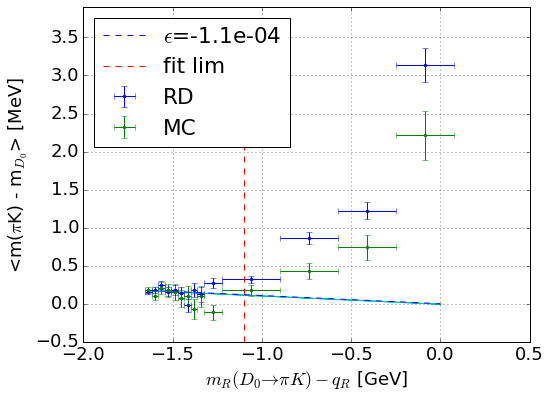

In [31]:
# bins = np.linspace(0.07, 1.8, 10)
bins = np.concatenate((np.linspace(0.07, 0.4, 10), np.linspace(0.5, 1.8, 5)))
avgRD = []
avgRDcorr = []
avgMC = []

# mCorr = varMass(df, sp1='pi', sp2='K', m1=m_pi, m2=m_K, scalePt=1+6.8e-4, shiftE=[0,0])
for i in range(len(bins)-1):
    m = bins[i]
    M = bins[i+1]   
    selRD = np.logical_and(xRD>m, xRD<M)
    avgRD.append(getAvg(mCorrBfield[selRD]))
#     avgRDcorr.append(getAvg(mCorr[selRD]))
    
    selMC = np.logical_and(xMC>m, xMC<M)
    avgMC.append(getAvg(df_MC['mass_piK'][selMC]))

avgRD = 1e3*np.array(avgRD)
avgRDcorr = 1e3*np.array(avgRDcorr)
avgMC = 1e3*np.array(avgMC)

x = (bins[1:] + bins[:-1])/2. - qR
dx = (bins[1:] - bins[:-1])/2.

plt.rcParams.update({'font.size': 18})
f = plt.figure(figsize=(8,6))

cut = 0.1
pval = 0
while pval < 0.05 and cut > -1.5:
    cut -= 0.1
    sel = x < cut
    m, dm, pval = fitLineFor0(x[sel], avgRD[sel,0]-1e3*m_D0, avgRD[sel,1])
print 'Magnetic field correction: {:1.2e} +/- {:1.2e}'.format(m*1e-3, dm*1e-3)
print 'pval: {:.1f}%'.format(100*pval)
plt.errorbar(x, avgRD[:,0]-1e3*m_D0, yerr=avgRD[:,1], xerr=dx, fmt='.', label='RD')
xline = np.array(list(x)+[0])
plt.fill_between(xline, (m+dm)*xline, (m-dm)*xline, color='c')
plt.plot(xline, m*xline, 'b--', label=r'$\epsilon$={:1.1e}'.format(1e-3*m))

# plt.errorbar(x, avgRDcorr[:,0]-1e3*m_D0, yerr=avgRDcorr[:,1], xerr=dx, fmt='.', label='RD corr')

plt.errorbar(x, avgMC[:,0]-1e3*m_D0, yerr=avgMC[:,1], xerr=dx, fmt='.', label='MC')

plt.xlabel(r'$m_R(D_0\to \pi K) - q_R$ [GeV]')
plt.ylabel('<m($\pi$K) - m$_{D_0}$> [MeV]')
ylim = plt.ylim()
plt.plot(2*[cut], ylim, '--', label='fit lim')
plt.ylim(ylim[0], ylim[1]+0.1*(ylim[1]-ylim[0]))
plt.legend(loc='best', numpoints=1)
plt.grid()

In [32]:
binsPt = np.array([0, 3.2, 5, 8, 12, 20])

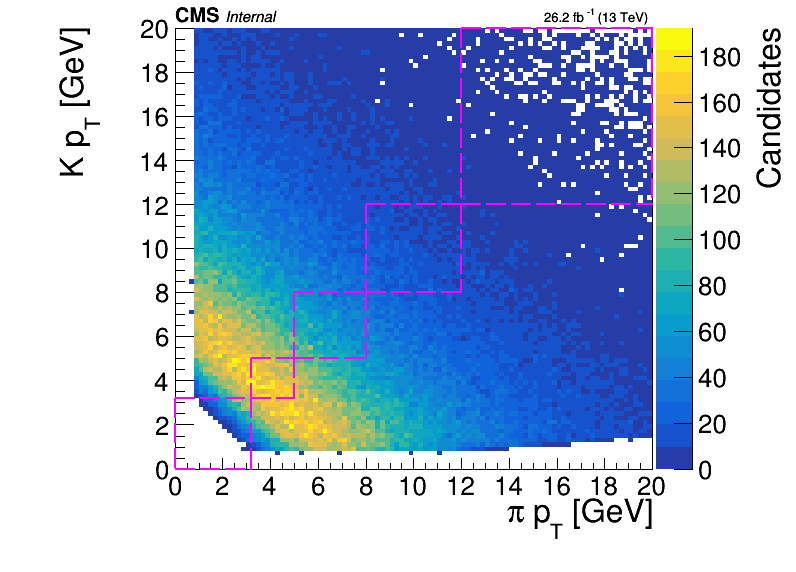

In [33]:
x = np.column_stack((df_MC['pi_pt'], df_MC['K_pt']))
h2 = create_TH2D(x, name='h_pt',
                 binning=[100,0,20,100,0,20],
                 axis_title=['#pi p_{T} [GeV]', 'K p_{T} [GeV]', 'Candidates']
                )
CC = drawOnCMSCanvas(CMS_lumi, [h2], ['colz'], tag='tl', mL=0.22, mR=0.18, mB=0.18)
for i in range(len(binsPt)-1):
    mpt = binsPt[i]
    Mpt = binsPt[i+1]
    cl.DrawLine(mpt, mpt, Mpt, mpt)
    cl.DrawLine(mpt, mpt, mpt, Mpt)
    cl.DrawLine(Mpt, Mpt, mpt, Mpt)
    cl.DrawLine(Mpt, Mpt, Mpt, mpt)

In [34]:
mCorr = varMass(df, sp1='pi', sp2='K', m1=m_pi, m2=m_K, scalePt=1+6.8e-4, shiftE=[0,0])

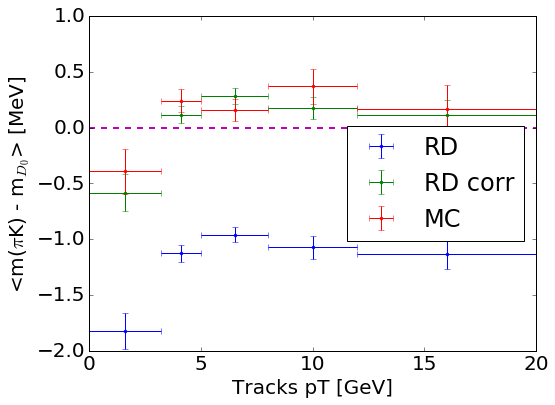

In [35]:
avgRD = []
avgRDcorr = []
avgMC = []

for i in range(len(binsPt)-1):
    mpt = binsPt[i]
    Mpt = binsPt[i+1]
    selm = np.logical_and(df['pi_pt']>mpt, df['K_pt']>mpt)
    selM = np.logical_and(df['pi_pt']<Mpt, df['K_pt']<Mpt)    
    selRD = np.logical_and(selm, selM)
    avgRD.append(getAvg(df['mass_piK'][selRD]))
    
    avgRDcorr.append(getAvg(mCorrBfield[selRD]))
    
    selm = np.logical_and(df_MC['pi_pt']>mpt, df_MC['K_pt']>mpt)
    selM = np.logical_and(df_MC['pi_pt']<Mpt, df_MC['K_pt']<Mpt)    
    selMC = np.logical_and(selm, selM)
    avgMC.append(getAvg(df_MC['mass_piK'][selMC]))

avgRD = 1e3*np.array(avgRD)
avgRDcorr = 1e3*np.array(avgRDcorr)
avgMC = 1e3*np.array(avgMC)

x = (binsPt[1:] + binsPt[:-1])/2.
dx = (binsPt[1:] - binsPt[:-1])/2.
plt.rcParams.update({'font.size': 20})
f = plt.figure(figsize=(8,6))
plt.plot(binsPt, [0]*len(binsPt), 'm--', lw=2)
plt.errorbar(x, avgRD[:,0]-1e3*m_D0, yerr=avgRD[:,1], xerr=dx, fmt='.', label='RD')
plt.errorbar(x, avgRDcorr[:,0]-1e3*m_D0, yerr=avgRDcorr[:,1], xerr=dx, fmt='.', label='RD corr')
plt.errorbar(x, avgMC[:,0]-1e3*m_D0, yerr=avgMC[:,1], xerr=dx, fmt='.', label='MC')
plt.legend(loc='best', numpoints=1)
plt.xlabel('Tracks pT [GeV]')
plt.ylabel('<m($\pi$K) - m$_{D_0}$> [MeV]')

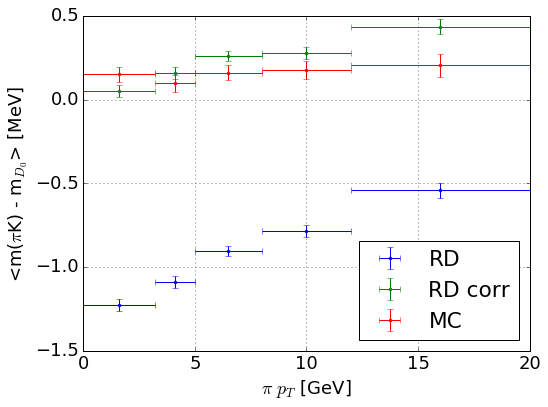

In [37]:
draw_dM_vs_x(mCorrBfield, df['pi_pt'], df_MC['pi_pt'], binsPt, r'$\pi\ p_T$ [GeV]')

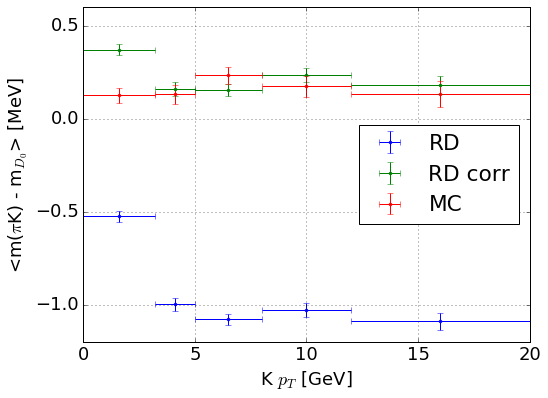

In [36]:
draw_dM_vs_x(mCorrBfield, df['K_pt'], df_MC['K_pt'], binsPt, r'K $p_T$ [GeV]')

## Mass of the Kaon in energy subtraction

In [88]:
def compute_rm(dset, scalePt=1., shiftE=[0,0], relSmear=0):
    if relSmear:
        sm1 = relSmear*np.random.randn(dset['pi_pt'].shape[0]) + 1.
        sm2 = relSmear*np.random.randn(dset['K_pt'].shape[0]) + 1.
    else:
        sm1 = 1.
        sm2 = 1.
    
    q2 = np.square(m_D0) - np.square(m_pi) - np.square(m_K)
    E_pi = np.hypot(m_pi, scalePt * dset['pi_pt'] * sm1 * np.cosh(dset['pi_eta'])) + shiftE[0]
    P_pi = np.sqrt(np.square(E_pi) - np.square(m_pi))
    E_K = np.hypot(m_K, scalePt * dset['K_pt'] * sm2 * np.cosh(dset['K_eta'])) + shiftE[1]
    P_K = np.sqrt(np.square(E_K) - np.square(m_K))
    
    beta_K = P_K/E_K
    P_K2 = np.square(P_K)
    
    a = np.sqrt(P_K2 + m_pi**2) - dEdx_ratio(P_K)*np.sqrt(P_K2 + m_K**2)
    a /= P_K2*m_D0
    a *= (np.square(beta_K) - 2)*E_pi*E_K + q2
    return a

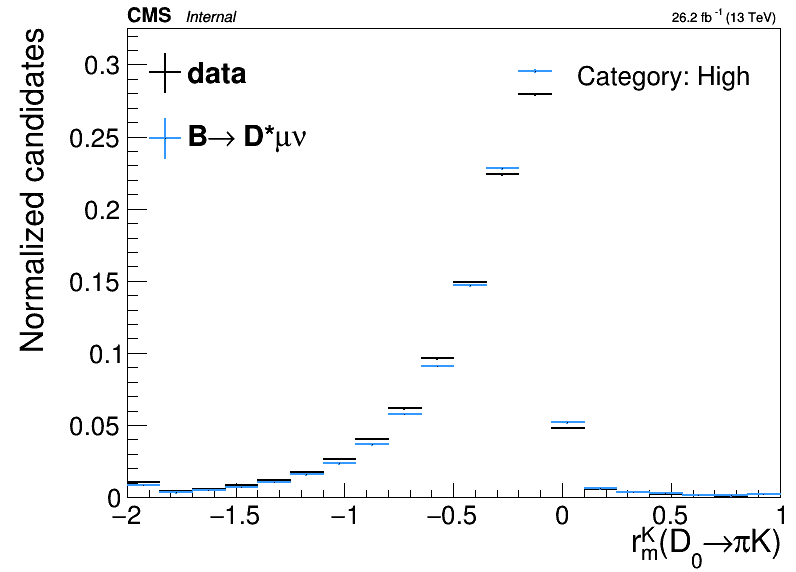

In [93]:
xMC = compute_rm(df_MC, scalePt=1.+6.8e-4)
xRD = compute_rm(df, scalePt=1.+6.8e-4)

C = drawVar(xRD, xMC, 
            binning=[20, -2, 1], 
            xtitle='r_{m}^{K}(D_{0}#rightarrow#piK)')#, legLoc=[0.4, 0.8, 0.7, 0.9])

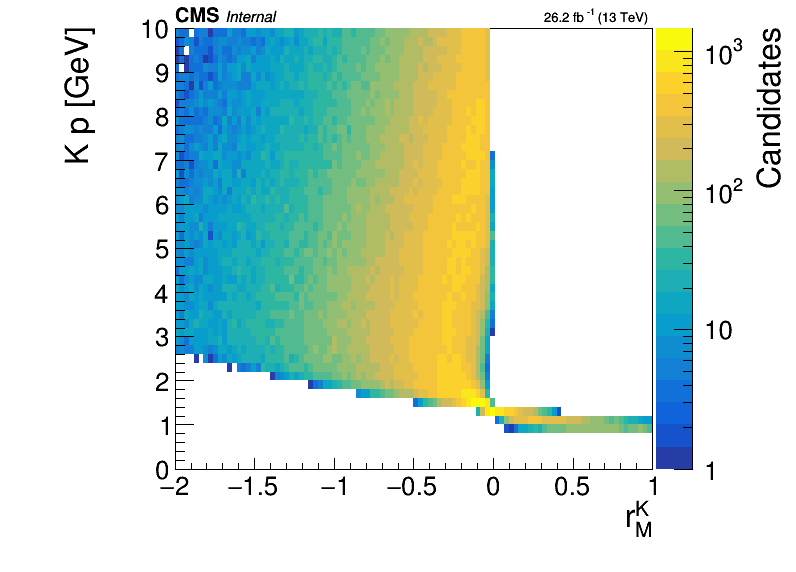

In [99]:
p_K = df['K_pt']*np.cosh(df['K_eta'])
x = np.column_stack((xRD, p_K))
h2 = create_TH2D(x, name='h_pt',
                 binning=[100,-2,1,50,0,10],
                 axis_title=['r_{M}^{K}', 'K p [GeV]', 'Candidates']
                )
CC = drawOnCMSCanvas(CMS_lumi, [h2], ['colz'], tag='tl', mL=0.22, mR=0.18, mB=0.18)
CC.SetLogz()

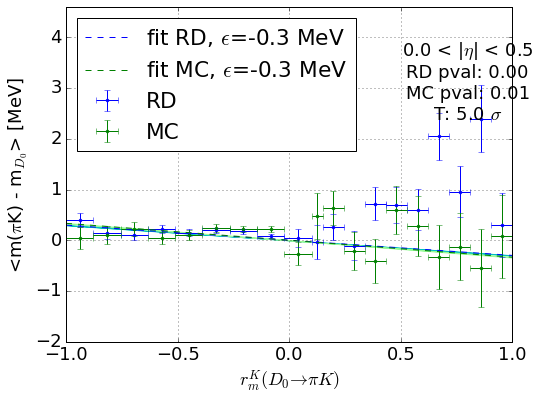

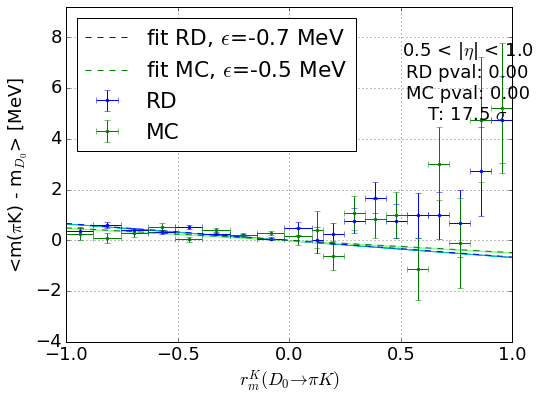

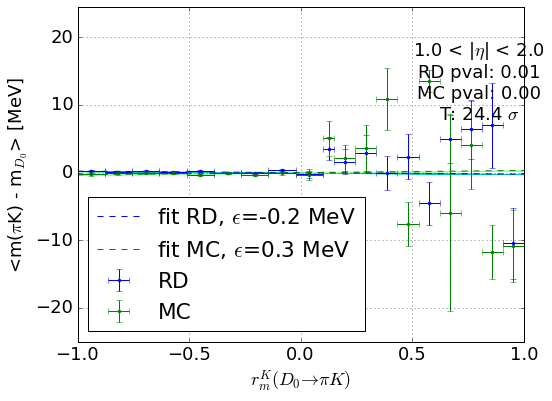

In [98]:
etaBins = [0., 0.5, 1., 2.]
for ie, (em, eM) in enumerate(zip(etaBins[:-1], etaBins[1:])):
    pStr = '{:.1f} < |$\eta$| < {:.1f}'.format(em, eM)
    bins = np.concatenate((np.linspace(-1, 0.1, 10), np.linspace(0.15, 1, 10)))
    avgRD = []
    avgRDcorr = []
    avgMC = []

    for m, M in zip(bins[:-1], bins[1:]):
        selRD = np.logical_and(xRD>m, xRD<M)
        selEta = np.logical_and(np.abs(df['K_eta']) > em, np.abs(df['K_eta']) < eM)
        selRD = np.logical_and(selRD, selEta)
        avgRD.append(getAvg(mCorrBfield[selRD]))

        selMC = np.logical_and(xMC>m, xMC<M)
        selEta = np.logical_and(np.abs(df_MC['K_eta']) > em, np.abs(df_MC['K_eta']) < eM)
        selMC = np.logical_and(selMC, selEta)
        avgMC.append(getAvg(df_MC['mass_piK'][selMC]))

    avgRD = 1e3*np.array(avgRD)
    avgMC = 1e3*np.array(avgMC)
    
    x = (bins[1:] + bins[:-1])/2.
    dx = (bins[1:] - bins[:-1])/2.
    
    sel = np.logical_not(np.isnan(avgMC[:,0]*avgRD[:,0]))
    m, dm, pval = fitLineFor0(x[sel], avgRD[sel,0]-1e3*m_D0, avgRD[sel,1])
    pStr += '\nRD pval: {:.2f}'.format(pval)
    plt.rcParams.update({'font.size': 18})
    f = plt.figure(figsize=(8,6))
    plt.errorbar(x, avgRD[:,0]-1e3*m_D0, yerr=avgRD[:,1], xerr=dx, fmt='.', label='RD')
    plt.fill_between(bins, (m+dm)*bins, (m-dm)*bins, color='c')
    plt.plot(bins, m*bins, 'b--', label=r'fit RD, $\epsilon$={:.1f} MeV'.format(m))
    mRD, dmRD = m, dm

    m, dm, pval = fitLineFor0(x[sel], avgMC[sel,0]-1e3*m_D0, avgMC[sel,1])
    pStr += '\nMC pval: {:.2f}'.format(pval)
    plt.errorbar(x, avgMC[:,0]-1e3*m_D0, yerr=avgMC[:,1], xerr=dx, fmt='.', label='MC')
    plt.fill_between(bins, (m+dm)*bins, (m-dm)*bins, color='palegreen')
    plt.plot(bins, m*bins, 'g--', label=r'fit MC, $\epsilon$={:.1f} MeV'.format(m))

    pStr += '\nT: {:.1f} $\sigma$'.format(np.abs(m-mRD)/np.hypot(dm, dmRD))

    # mAux = varMass(df, sp1='pi', sp2='K', m1=m_pi, m2=m_K, scalePt=1+6.6e-4, shiftE=[0,0])
    # for m, M in zip(bins[:-1], bins[1:]):
    #     selRD = np.logical_and(xRD>m, xRD<M)
    #     avgRDcorr.append(getAvg(mAux[selRD]))
    # avgRDcorr = 1e3*np.array(avgRDcorr)
    # plt.errorbar(x, avgRDcorr[:,0]-1e3*m_D0, yerr=avgRDcorr[:,1], xerr=dx, fmt='.', label='RD corr')

    plt.xlabel(r'$r_m^K(D_0\to \pi K)$')
    plt.ylabel('<m($\pi$K) - m$_{D_0}$> [MeV]')
    ylim = plt.ylim()
    plt.text(0.8, ylim[1], pStr, horizontalalignment='center', verticalalignment='top', multialignment='center')
    plt.ylim(ylim[0], ylim[1]+0.1*(ylim[1]-ylim[0]))
    plt.legend(loc='best', numpoints=1)
    plt.grid()

## Energy loss effects

In [43]:
def compute_rC(dset, sp1='pi', sp2='K', m1=m_pi, m2=m_K, M=m_D0, scalePt=1., shiftE=[0,0], relSmear=0):
    if relSmear:
        sm1 = relSmear*np.random.randn(dset[sp1+'_pt'].shape[0]) + 1.
        sm2 = relSmear*np.random.randn(dset[sp2+'_pt'].shape[0]) + 1.
    else:
        sm1 = 1.
        sm2 = 1.
    
    q2 = np.square(M) - np.square(m1) - np.square(m2)
    E1 = np.hypot(m1, scalePt * dset[sp1+'_pt'] * sm1 * np.cosh(dset[sp1+'_eta'])) + shiftE[0]
    P1 = np.sqrt(np.square(E1) - np.square(m1))
    E2 = np.hypot(m2, scalePt * dset[sp2+'_pt'] * sm2 * np.cosh(dset[sp2+'_eta'])) + shiftE[1]
    P2 = np.sqrt(np.square(E2) - np.square(m2))
    
    rC_1 = E1*(E2/E1 + 0.5*(q2-2*E1*E2)/np.square(P1))/M
    rC_2 = E2*(E1/E2 + 0.5*(q2-2*E1*E2)/np.square(P2))/M
    return np.column_stack((rC_1, rC_2))

In [44]:
def getEnergy(dset, sp='pi', m=m_pi, scalePt=1., shiftE=0, relSmear=0):
    if relSmear:
        sm = relSmear*np.random.randn(dset[sp1+'_pt'].shape[0]) + 1.
    else:
        sm = 1.
    E = np.hypot(m, scalePt * dset[sp+'_pt'] * sm * np.cosh(dset[sp+'_eta'])) + shiftE
    return E

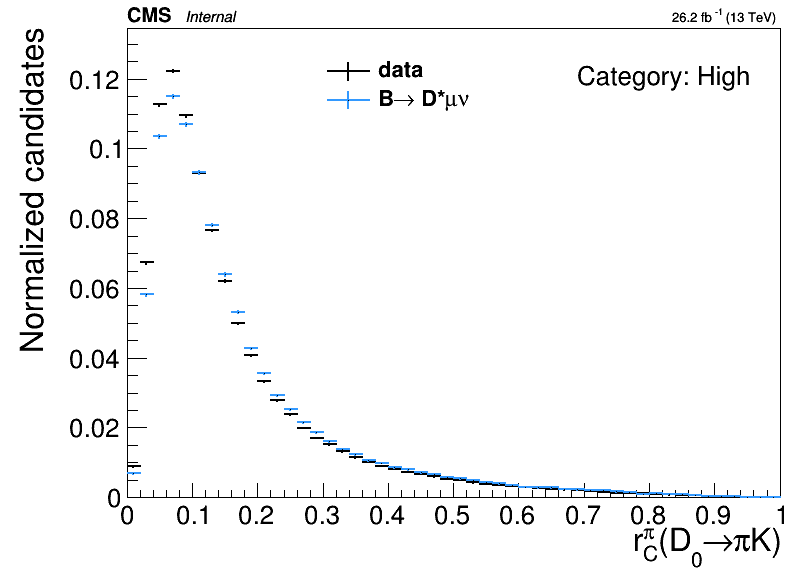

In [100]:
xMC = compute_rC(df_MC, scalePt=1.+6.6e-4)
xRD = compute_rC(df, scalePt=1.+6.6e-4)

C = drawVar(xRD[:,0], xMC[:,0], binning=[50, 0.0, 1.], xtitle='r_{C}^{#pi}(D_{0}#rightarrow#piK)', legLoc=[0.4, 0.8, 0.7, 0.9])
# C.SetLogy()

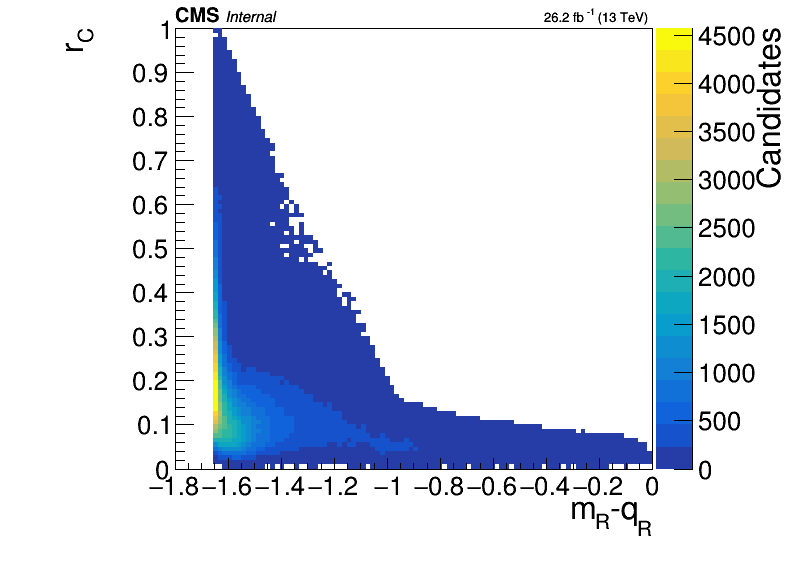

In [101]:
q2 = m_D0**2 - m_pi**2 - m_K**2
qR = q2/m_D0
x1 = compute_mR(df) - qR
x = np.column_stack((x1, np.max(xRD, axis=1)))
h2 = create_TH2D(x, name='h_pt',
                 binning=[100,-1.8,0,100,0,1],
                 axis_title=['m_{R}-q_{R}', 'r_{C}', 'Candidates']
                )
CC = drawOnCMSCanvas(CMS_lumi, [h2], ['colz'], tag='tl', mL=0.22, mR=0.18, mB=0.18)

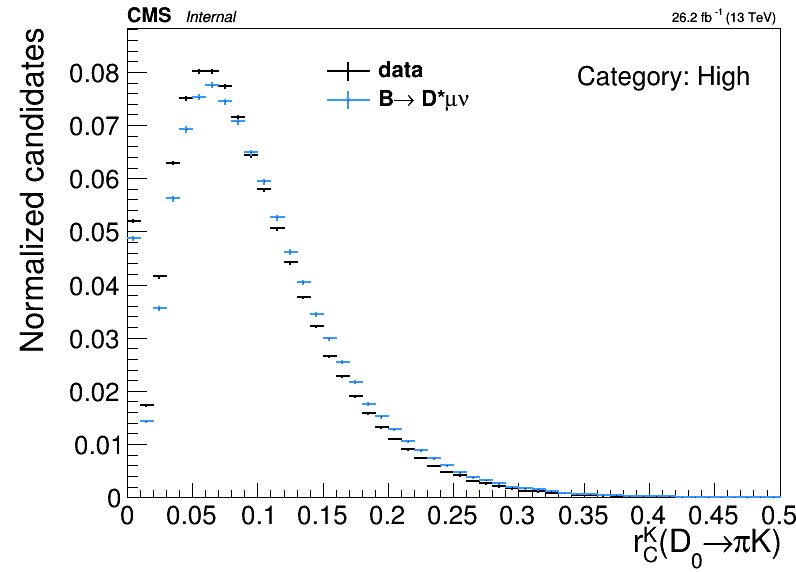

In [102]:
C2 = drawVar(xRD[:,1], xMC[:,1], binning=[50, 0.0, .5], xtitle='r_{C}^{K}(D_{0}#rightarrow#piK)', legLoc=[0.4, 0.8, 0.7, 0.9])
# C2.SetLogy()

Pion energy correction: 4.61e-01 +/- 5.54e-03
pval: 0.0%


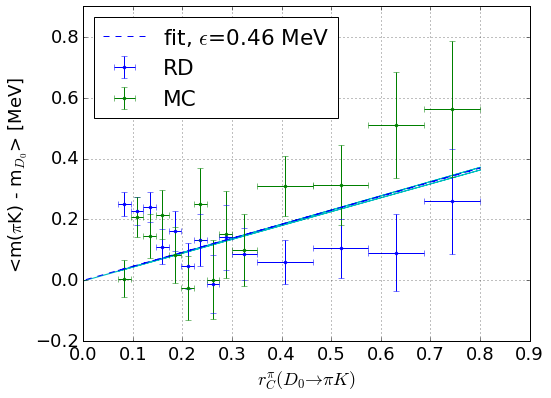

In [103]:
bins = np.concatenate((np.linspace(0.07, 0.3, 10), np.linspace(0.35, 0.8, 5)))
avgRD = []
avgMC = []

for i in range(len(bins)-1):
    m = bins[i]
    M = bins[i+1]   
    selRD = np.logical_and(xRD[:,0]>m, xRD[:,0]<M)
    selRD = np.logical_and(selRD, df['K_pt']*np.cosh(df['K_eta']) > 1.3)
    avgRD.append(getAvg(mCorrBfield[selRD]))
    
    selMC = np.logical_and(xMC[:,0]>m, xMC[:,0]<M)
    selMC = np.logical_and(selMC, df_MC['K_pt']*np.cosh(df_MC['K_eta']) > 1.3)
    avgMC.append(getAvg(df_MC['mass_piK'][selMC]))

avgRD = 1e3*np.array(avgRD)
avgMC = 1e3*np.array(avgMC)

x = (bins[1:] + bins[:-1])/2.
dx = (bins[1:] - bins[:-1])/2.

m, dm, pval = fitLineFor0(x, avgRD[:,0]-1e3*m_D0, avgRD[:,1])
print 'Pion energy correction: {:1.2e} +/- {:1.2e}'.format(m, dm)
print 'pval: {:.1f}%'.format(100*pval)

plt.rcParams.update({'font.size': 18})
f = plt.figure(figsize=(8,6))
plt.errorbar(x, avgRD[:,0]-1e3*m_D0, yerr=avgRD[:,1], xerr=dx, fmt='.', label='RD')
xlist = np.array(list(bins) + [0])
plt.plot(xlist, xlist*m, 'b--', label=r'fit, $\epsilon$={:.2f} MeV'.format(m))
plt.fill_between(xlist, (m+dm)*xlist, (m-dm)*xlist, color='c')

# avgRDcorr = []
# for i in range(len(bins)-1):
#     m = bins[i]
#     M = bins[i+1]   
#     mCorr = varMass(df, sp1='pi', sp2='K', m1=m_pi, m2=m_K, scalePt=1+6.8e-4, shiftE=[1e-3*m,0])
#     selRD = np.logical_and(xRD[:,0]>m, xRD[:,0]<M)
#     avgRDcorr.append(getAvg(mCorr[selRD]))
# avgRDcorr = 1e3*np.array(avgRDcorr)

# plt.errorbar(x, avgRDcorr[:,0]-1e3*m_D0, yerr=avgRDcorr[:,1], xerr=dx, fmt='.', label='RD corr')

plt.errorbar(x, avgMC[:,0]-1e3*m_D0, yerr=avgMC[:,1], xerr=dx, fmt='.', label='MC')


plt.xlabel(r'$r_C^\pi(D_0\to \pi K)$')
plt.ylabel('<m($\pi$K) - m$_{D_0}$> [MeV]')
ylim = plt.ylim()
plt.ylim(ylim[0], ylim[1]+0.1*(ylim[1]-ylim[0]))
plt.legend(loc='best', numpoints=1)
plt.grid()

Kaon energy correction: 7.11e-01 +/- 1.80e-02
pval: 0.0%


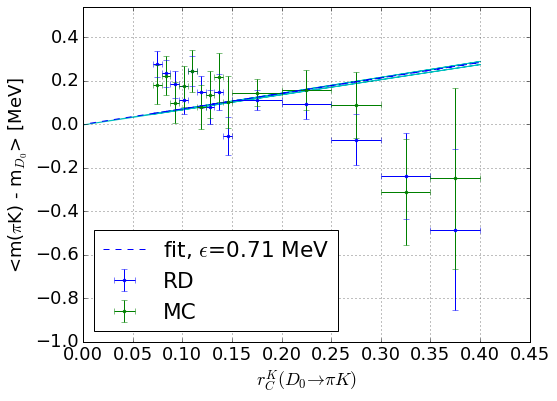

In [104]:
bins = np.concatenate((np.linspace(0.07, 0.15, 10), np.linspace(0.2, 0.4, 5)))
avgRD = []
avgMC = []

for i in range(len(bins)-1):
    m = bins[i]
    M = bins[i+1]   
    selRD = np.logical_and(xRD[:,1]>m, xRD[:,1]<M)
    avgRD.append(getAvg(mCorrBfield[selRD]))
    
    selMC = np.logical_and(xMC[:,1]>m, xMC[:,1]<M)
    avgMC.append(getAvg(df_MC['mass_piK'][selMC]))

avgRD = 1e3*np.array(avgRD)
avgMC = 1e3*np.array(avgMC)

x = (bins[1:] + bins[:-1])/2.
dx = (bins[1:] - bins[:-1])/2.

m, dm, pval = fitLineFor0(x, avgRD[:,0]-1e3*m_D0, avgRD[:,1])
print 'Kaon energy correction: {:1.2e} +/- {:1.2e}'.format(m, dm)
print 'pval: {:.1f}%'.format(100*pval)

plt.rcParams.update({'font.size': 18})
f = plt.figure(figsize=(8,6))
plt.errorbar(x, avgRD[:,0]-1e3*m_D0, yerr=avgRD[:,1], xerr=dx, fmt='.', label='RD')
xlist = np.array(list(bins) + [0])
plt.plot(xlist, xlist*m, 'b--', label=r'fit, $\epsilon$={:.2f} MeV'.format(m))
plt.fill_between(xlist, (m+dm)*xlist, (m-dm)*xlist, color='c')

# avgRDcorr = []
# for i in range(len(bins)-1):
#     m = bins[i]
#     M = bins[i+1]   
#     mCorr = varMass(df, sp1='pi', sp2='K', m1=m_pi, m2=m_K, scalePt=1+6.8e-4, shiftE=[1e-3*m,0])
#     selRD = np.logical_and(xRD[:,0]>m, xRD[:,0]<M)
#     avgRDcorr.append(getAvg(mCorr[selRD]))
# avgRDcorr = 1e3*np.array(avgRDcorr)

# plt.errorbar(x, avgRDcorr[:,0]-1e3*m_D0, yerr=avgRDcorr[:,1], xerr=dx, fmt='.', label='RD corr')

plt.errorbar(x, avgMC[:,0]-1e3*m_D0, yerr=avgMC[:,1], xerr=dx, fmt='.', label='MC')


plt.xlabel(r'$r_C^K(D_0\to \pi K)$')
plt.ylabel('<m($\pi$K) - m$_{D_0}$> [MeV]')
ylim = plt.ylim()
plt.ylim(ylim[0], ylim[1]+0.1*(ylim[1]-ylim[0]))
plt.legend(loc='best', numpoints=1)
plt.grid()

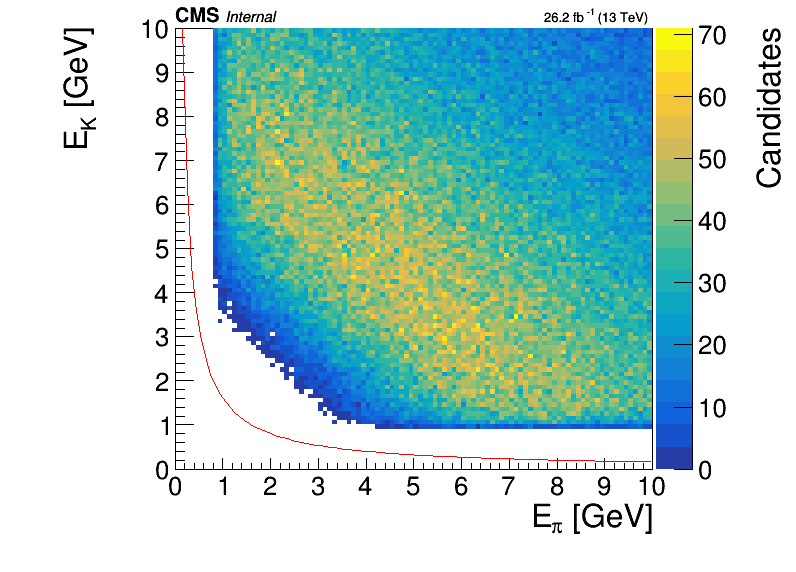

In [56]:
Epi = getEnergy(df, 'pi', m_pi, scalePt=1+6.6e-4)
EK = getEnergy(df, 'K', m_K, scalePt=1+6.6e-4)
h2 = create_TH2D(np.column_stack((Epi, EK)), name='h_betaG',
                 binning=[100, 0, 10,100, 0, 10],
                 axis_title=['E_{#pi} [GeV]', 'E_{K} [GeV]', 'Candidates']
                )
CC = drawOnCMSCanvas(CMS_lumi, [h2], ['colz'], tag='tl', mL=0.22, mR=0.18, mB=0.18)

f = rt.TF1('f0', '{}/(2*x)'.format(q2), h2.binning[1], h2.binning[2])
f.Draw('same')

### Mass in different regions of $\beta\gamma$

In [107]:
# h2 = create_TH2D(bgMC, name='h_betaG',
#                  binning=[100,0,70,100,0,50],
#                  axis_title=['#pi #beta#gamma', 'K #beta#gamma', 'Candidates']
#                 )
# CC = drawOnCMSCanvas(CMS_lumi, [h2], ['colz'], tag='tl', mL=0.22, mR=0.18, mB=0.18)
# cPi = 20.
# cK=20.
# cl.DrawLine(0,cK,cPi,cK)
# cl.DrawLine(cPi,0,cPi,cK)

In [108]:
# x = np.column_stack((df_MC['pi_pt'], df_MC['pi_pt']-df_MC['MC_pi_pt']))
# h2 = create_TH2D(x, binning=[7, 0, 20, 100, -0.4, 0.4], axis_title=['#pi p_{T} [GeV]', '#pi p_{T}^{RECO}-p_{T}^{MC} [GeV]', ''])
# h2.SetFillStyle(0)
# C = drawOnCMSCanvas(CMS_lumi, [h2, h2], ['colz', 'sameCANDLEX3'], tag='tl', mL=0.22, mR=0.18, mB=0.18)

In [109]:
# x = np.column_stack((bgMC[:,1], df_MC['K_pt']-df_MC['MC_K_pt']))
# h2 = create_TH2D(x, binning=[7, 0, 70, 100, -0.4, 0.4], axis_title=['K #beta#gamma [GeV]', 'K p_{T}^{RECO}-p_{T}^{MC} [GeV]', ''])
# h2.SetFillStyle(0)
# C = drawOnCMSCanvas(CMS_lumi, [h2, h2], ['colz', 'sameCANDLEX3'], tag='tl', mL=0.22, mR=0.18, mB=0.18)

In [110]:
# leg = rt.TLegend(0.18, 0.7, 0.5, 0.93)
# leg.SetBorderSize(0)
# leg.SetFillStyle(0)
# h_list=[]

# selRD = np.logical_and(bgRD[:,0]<cPi, bgRD[:,1]<cK)
# h = create_TH1D(df['mass_piK'][selRD], name='RDlow',
#                 binning=[60, m_D0-0.04, m_D0+0.035], 
#                 axis_title=['M(#piK) [GeV]', 'Normalized candidates'],
#                 scale_histo='norm',
#                 opt='overflow+underflow'
#                )
# m = 1e3*(np.mean(df['mass_piK'][selRD])-m_D0)
# s = 1e3*np.std(df['mass_piK'][selRD])
# leg.AddEntry(h, 'RD low #beta, avg: {:.2f} +/- {:.2f} MeV'.format(m, s/np.sqrt(np.sum(selRD))), 'lep')
# h_list.append(h)

# selMC = np.logical_and(bgMC[:,0]<cPi, bgMC[:,1]<cK)
# h = create_TH1D(df_MC['mass_piK'][selMC], name='MClow',
#                 binning=h.binning, scale_histo='norm', opt='overflow+underflow')
# h.SetLineColor(2)
# m = 1e3*(np.mean(df_MC['mass_piK'][selMC])-m_D0)
# s = 1e3*np.std(df_MC['mass_piK'][selMC])
# leg.AddEntry(h, 'MC low #beta, avg: {:.2f} +/- {:.2f} MeV'.format(m, s/np.sqrt(np.sum(selRD))), 'lep')
# h_list.append(h)


# m = SetMaxToMaxHist(h_list)
# c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
# catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
# h.Sumw2()
# leg.Draw()
# cl.DrawLine(m_D0, 0, m_D0, m)

In [111]:
# leg = rt.TLegend(0.18, 0.7, 0.5, 0.93)
# leg.SetBorderSize(0)
# leg.SetFillStyle(0)
# h_list=[]

# selRD = np.logical_and(bgRD[:,0]>cPi, bgRD[:,1]>cK)
# h = create_TH1D(df['mass_piK'][selRD], name='RDlow',
#                 binning=[60, m_D0-0.04, m_D0+0.035], 
#                 axis_title=['M(#piK) [GeV]', 'Normalized candidates'],
#                 scale_histo='norm',
#                 opt='overflow+underflow'
#                )
# m = 1e3*(np.mean(df['mass_piK'][selRD])-m_D0)
# s = 1e3*np.std(df['mass_piK'][selRD])
# leg.AddEntry(h, 'RD high #beta, avg: {:.2f} +/- {:.2f} MeV'.format(m, s/np.sqrt(np.sum(selRD))), 'lep')
# h_list.append(h)

# selMC = np.logical_and(bgMC[:,0]>cPi, bgMC[:,1]>cK)
# h = create_TH1D(df_MC['mass_piK'][selMC], name='MClow',
#                 binning=h.binning, scale_histo='norm', opt='overflow+underflow')
# h.SetLineColor(2)
# m = 1e3*(np.mean(df_MC['mass_piK'][selMC])-m_D0)
# s = 1e3*np.std(df_MC['mass_piK'][selMC])
# leg.AddEntry(h, 'MC high #beta, avg: {:.2f} +/- {:.2f} MeV'.format(m, s/np.sqrt(np.sum(selRD))), 'lep')
# h_list.append(h)


# m = SetMaxToMaxHist(h_list)
# c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
# catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')
# h.Sumw2()
# leg.Draw()
# cl.DrawLine(m_D0, 0, m_D0, m)

In [112]:
# binsBG = np.array([0, 10, 15, 20, 30, 50, 70])

In [113]:
# bgMC = np.column_stack((df_MC['pi_pt']*np.cosh(df_MC['pi_eta'])/m_pi, 
#                         df_MC['K_pt']*np.cosh(df_MC['K_eta'])/m_K
#                        ))
# h2 = create_TH2D(bgMC, name='h_betaG',
#                  binning=[100,0,70,100,0,70],
#                  axis_title=['#pi #beta#gamma', 'K #beta#gamma', 'Candidates']
#                 )
# CC = drawOnCMSCanvas(CMS_lumi, [h2], ['colz'], tag='tl', mL=0.22, mR=0.18, mB=0.18)
# for i in range(len(binsBG)-1):
#     mpt = binsBG[i]
#     Mpt = binsBG[i+1]
#     cl.DrawLine(mpt, mpt, Mpt, mpt)
#     cl.DrawLine(mpt, mpt, mpt, Mpt)
#     cl.DrawLine(Mpt, Mpt, mpt, Mpt)
#     cl.DrawLine(Mpt, Mpt, Mpt, mpt)

In [114]:
# bgMC = np.column_stack((df_MC['pi_pt']*np.cosh(df_MC['pi_eta'])/m_pi, df_MC['K_pt']*np.cosh(df_MC['K_eta'])/m_K))
# bgRD = np.column_stack((df['pi_pt']*np.cosh(df['pi_eta'])/m_pi, df['K_pt']*np.cosh(df['K_eta'])/m_K))

# avgRD = []
# avgMC = []

# for i in range(len(binsBG)-1):
#     m = binsBG[i]
#     M = binsBG[i+1]
#     selm = np.logical_and(bgRD[:,0]>m, bgRD[:,1]>m)
#     selM = np.logical_and(bgRD[:,0]<M, bgRD[:,1]<M)    
#     selRD = np.logical_and(selm, selM)
#     avgRD.append(getAvg(df['mass_piK'][selRD]))
    
#     selm = np.logical_and(bgMC[:,0]>m, bgMC[:,1]>m)
#     selM = np.logical_and(bgMC[:,0]<M, bgMC[:,1]<M)    
#     selMC = np.logical_and(selm, selM)
#     avgMC.append(getAvg(df_MC['mass_piK'][selMC]))

# avgRD = 1e3*np.array(avgRD)
# avgMC = 1e3*np.array(avgMC)

# x = (binsBG[1:] + binsBG[:-1])/2.
# dx = (binsBG[1:] - binsBG[:-1])/2.
# plt.rcParams.update({'font.size': 20})
# f = plt.figure(figsize=(8,6))
# plt.errorbar(x, avgRD[:,0]-1e3*m_D0, yerr=avgRD[:,1], xerr=dx, fmt='.', label='RD')
# plt.errorbar(x, avgMC[:,0]-1e3*m_D0, yerr=avgMC[:,1], xerr=dx, fmt='.', label='MC')
# plt.legend(loc='best', numpoints=1)
# plt.xlabel(r'Tracks $\beta \gamma$')
# plt.ylabel('<m($\pi$K) - m$_{D_0}$> [MeV]')

In [115]:
# np.polyfit(x, avgMC[:,0]-1e3*m_D0, 1, w = 1./avgMC[:,1])

In [116]:
# avgRD = []
# avgRDcorr = []
# avgMC = []

# for i in range(len(binsBG)-1):
#     m = binsBG[i]
#     M = binsBG[i+1]
  
#     selRD = np.logical_and(bgRD[:,1]>m, bgRD[:,1]<M)
#     avgRD.append(getAvg(df['mass_piK'][selRD]))
    
#     m_coor = varMass(df, sp1='pi', sp2='K', m1=m_pi, m2=m_K, scalePt=1, shiftE=[0,-1e-3])
#     avgRDcorr.append(getAvg(m_coor[selRD]))

#     selMC = np.logical_and(bgMC[:,1]>m, bgMC[:,1]<M)
#     avgMC.append(getAvg(df_MC['mass_piK'][selMC]))

# avgRD = 1e3*np.array(avgRD)
# avgRDcorr = 1e3*np.array(avgRDcorr)
# avgMC = 1e3*np.array(avgMC)

# x = (binsBG[1:] + binsBG[:-1])/2.
# dx = (binsBG[1:] - binsBG[:-1])/2.
# plt.rcParams.update({'font.size': 20})
# f = plt.figure(figsize=(8,6))
# plt.errorbar(x, avgRD[:,0]-1e3*m_D0, yerr=avgRD[:,1], xerr=dx, fmt='.', label='RD')
# plt.errorbar(x, avgRDcorr[:,0]-1e3*m_D0, yerr=avgRDcorr[:,1], xerr=dx, fmt='.', label='RDcorr')
# plt.errorbar(x, avgMC[:,0]-1e3*m_D0, yerr=avgMC[:,1], xerr=dx, fmt='.', label='MC')
# plt.legend(loc='best', numpoints=1)
# plt.xlabel(r'K $\beta \gamma$')
# plt.ylabel('<m($\pi$K) - m$_{D_0}$> [MeV]')

In [117]:
# avgRD = []
# avgMC = []

# for i in range(len(binsBG)-1):
#     m = binsBG[i]
#     M = binsBG[i+1]
  
#     selRD = np.logical_and(bgRD[:,0]>m, bgRD[:,0]<M)
#     avgRD.append(getAvg(df['mass_piK'][selRD]))

#     selMC = np.logical_and(bgMC[:,0]>m, bgMC[:,0]<M)
#     avgMC.append(getAvg(df_MC['mass_piK'][selMC]))

# avgRD = 1e3*np.array(avgRD)
# avgMC = 1e3*np.array(avgMC)

# x = (binsBG[1:] + binsBG[:-1])/2.
# dx = (binsBG[1:] - binsBG[:-1])/2.
# plt.rcParams.update({'font.size': 20})
# f = plt.figure(figsize=(8,6))
# plt.errorbar(x, avgRD[:,0]-1e3*m_D0, yerr=avgRD[:,1], xerr=dx, fmt='.', label='RD')
# plt.errorbar(x, avgMC[:,0]-1e3*m_D0, yerr=avgMC[:,1], xerr=dx, fmt='.', label='MC')
# plt.legend(loc='best', numpoints=1)
# plt.xlabel(r'$\pi$ $\beta \gamma$')
# plt.ylabel('<m($\pi$K) - m$_{D_0}$> [MeV]')

In [118]:
# avgRD = []
# avgMC = []
# avgRDcorr = []


# for i in range(len(binsPt)-1):
#     m = binsPt[i]
#     M = binsPt[i+1] 
#     selRD = np.logical_and(df['K_pt']>m, df['K_pt']<M)
#     avgRD.append(getAvg(df['mass_piK'][selRD]))
    
#     m_coor = varMass(df, sp1='pi', sp2='K', m1=m_pi, m2=m_K, scalePt=1+7e-4, shiftE=[0.,-1e-3])
#     avgRDcorr.append(getAvg(m_coor[selRD]))
     
#     selMC = np.logical_and(df_MC['K_pt']>m, df_MC['K_pt']<M)
#     avgMC.append(getAvg(df_MC['mass_piK'][selMC]))

# avgRD = 1e3*np.array(avgRD)
# avgRDcorr = 1e3*np.array(avgRDcorr)
# avgMC = 1e3*np.array(avgMC)

# x = (binsPt[1:] + binsPt[:-1])/2.
# dx = (binsPt[1:] - binsPt[:-1])/2.
# plt.rcParams.update({'font.size': 20})
# f = plt.figure(figsize=(8,6))
# plt.errorbar(x, avgRD[:,0]-1e3*m_D0, yerr=avgRD[:,1], xerr=dx, fmt='.', label='RD')
# plt.errorbar(x, avgRDcorr[:,0]-1e3*m_D0, yerr=avgRDcorr[:,1], xerr=dx, fmt='.', label='RDcorr')
# plt.errorbar(x, avgMC[:,0]-1e3*m_D0, yerr=avgMC[:,1], xerr=dx, fmt='.', label='MC')
# plt.legend(loc='best', numpoints=1)
# plt.xlabel(r'K $P_T$ [GeV]')
# plt.ylabel('<m($\pi$K) - m$_{D_0}$> [MeV]')

In [119]:
# avgRD = []
# avgMC = []

# for i in range(len(binsPt)-1):
#     m = binsPt[i]
#     M = binsPt[i+1] 
#     selRD = np.logical_and(df['pi_pt']>m, df['pi_pt']<M)
#     avgRD.append(getAvg(df['mass_piK'][selRD]))
     
#     selMC = np.logical_and(df_MC['pi_pt']>m, df_MC['pi_pt']<M)
#     avgMC.append(getAvg(df_MC['mass_piK'][selMC]))

# avgRD = 1e3*np.array(avgRD)
# avgMC = 1e3*np.array(avgMC)

# x = (binsPt[1:] + binsPt[:-1])/2.
# dx = (binsPt[1:] - binsPt[:-1])/2.
# plt.rcParams.update({'font.size': 20})
# f = plt.figure(figsize=(8,6))
# plt.errorbar(x, avgRD[:,0]-1e3*m_D0, yerr=avgRD[:,1], xerr=dx, fmt='.', label='RD')
# plt.errorbar(x, avgMC[:,0]-1e3*m_D0, yerr=avgMC[:,1], xerr=dx, fmt='.', label='MC')
# plt.legend(loc='best', numpoints=1)
# plt.xlabel(r'$\pi$ $P_T$ [GeV]')
# plt.ylabel('<m($\pi$K) - m$_{D_0}$> [MeV]')

# D* observables

In [127]:
mDst, mD0 = varMass_3(df, sp1='pi', sp2='K', sp3='pis', m1=m_pi, m2=m_K, m3=m_pi, returnM12=True)
mDstMC, mD0MC = varMass_3(df_MC, sp1='pi', sp2='K', sp3='pis', m1=m_pi, m2=m_K, m3=m_pi, returnM12=True)
mDstC, mD0C = varMass_3(df, sp1='pi', sp2='K', sp3='pis', m1=m_pi, m2=m_K, m3=m_pi, returnM12=True, applyBmap=True)

Average magnetic field correction: 7.9e-04


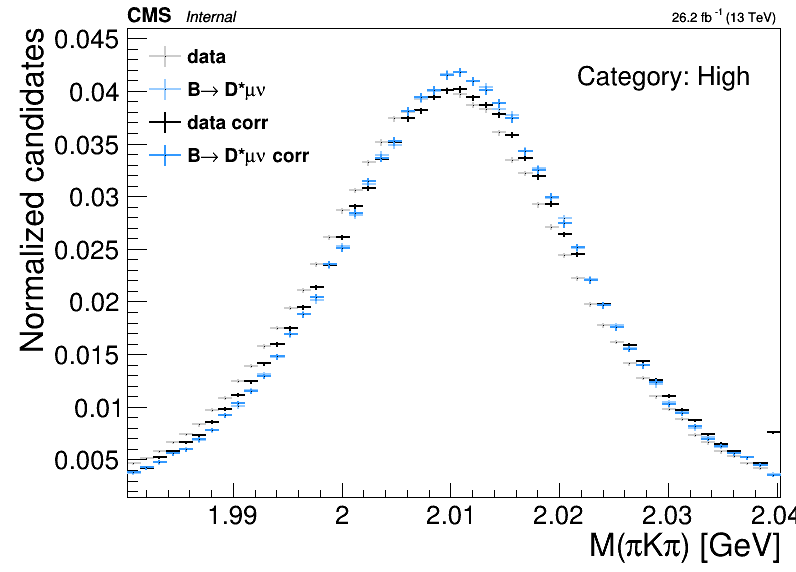

In [133]:
C = drawVar(varRD=df['mass_D0pis'], 
            varMC=df_MC['mass_D0pis'],
            varRDcorr=mDstC,
            varMCcorr=mDstMC,
            binning=[50, m_Dst-0.03, m_Dst+0.03], 
            xtitle='M(#piK#pi) [GeV]')

In [134]:
print np.percentile(mDstC, 85) - np.percentile(mDstC, 15)
print np.percentile(mDstMC, 85) - np.percentile(mDstMC, 15)

0.02559440090333176
0.024817245327333426


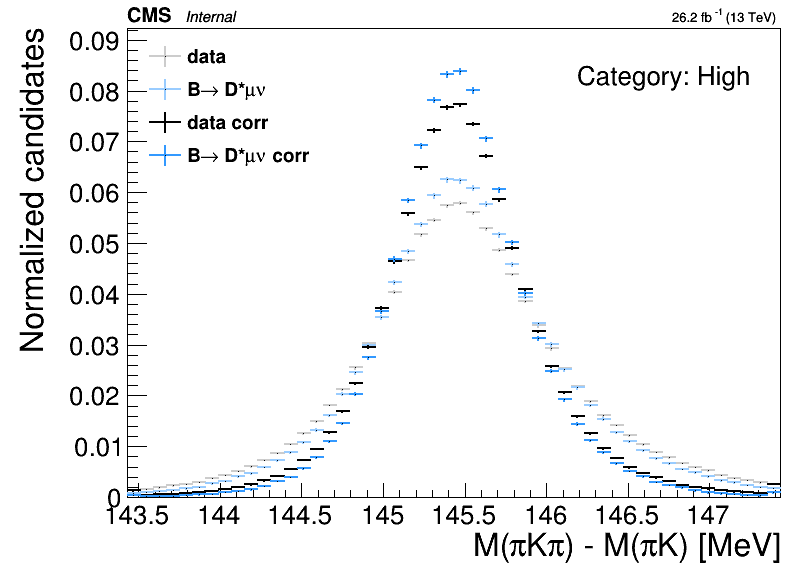

In [135]:
C = drawVar(varRD=1e3*(df['mass_D0pis'] - df['mass_piK']),
            varMC=1e3*(df_MC['mass_D0pis'] - df_MC['mass_piK']),
            varRDcorr=1e3*(mDstC - mD0C),
            varMCcorr=1e3*(mDstMC - mD0MC),
            binning=[50, 1e3*(m_Dst-m_D0) - 2, 1e3*(m_Dst-m_D0) + 2], 
            xtitle='M(#piK#pi) - M(#piK) [MeV]')

<ROOT.TLine object ("TLine") at 0xbd2b610>

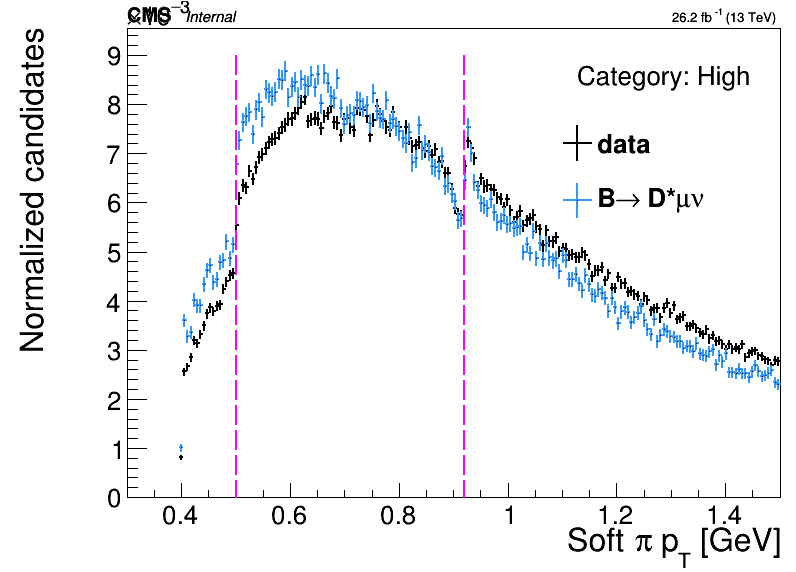

In [158]:
C = drawVar(varRD=df['pis_pt'], 
            varMC=df_MC['pis_pt'],
            opt='',
            binning=[200, 0.3, 1.5], 
            xtitle='Soft #pi p_{T} [GeV]', 
            legLoc=[0.7, 0.6, 0.9, 0.8])

cl.DrawLine(0.5, 0, 0.5, 9e-3)
cl.DrawLine(0.92, 0, 0.92, 9e-3)

In [162]:
dm_RD = 1e3*(mDstC - mD0C)
dm_MC = 1e3*(mDstMC - mD0MC)

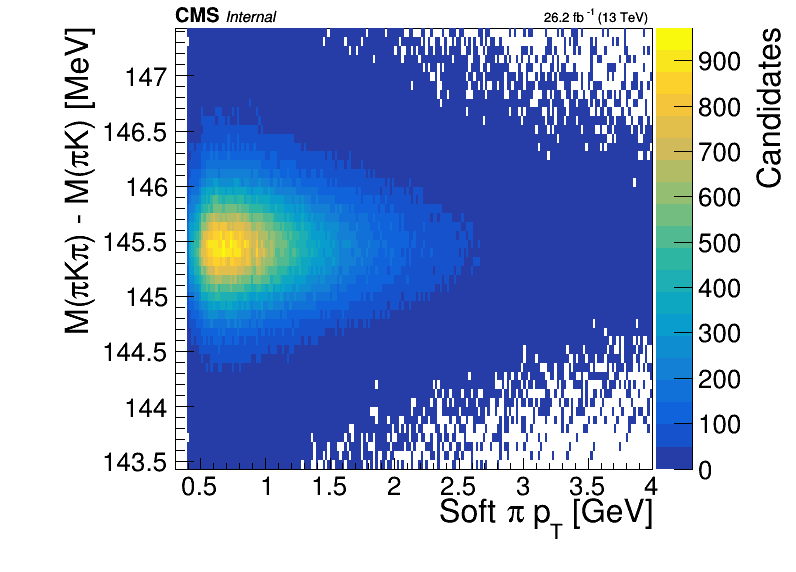

In [163]:
h2 = create_TH2D(np.column_stack((df['pis_pt'], dm_RD)), name='h2',
                 binning=[200, 0.3, 4, 50, 1e3*(m_Dst-m_D0) - 2, 1e3*(m_Dst-m_D0) + 2],
                 axis_title=['Soft #pi p_{T} [GeV]', 'M(#piK#pi) - M(#piK) [MeV]', 'Candidates']
                )
CC = drawOnCMSCanvas(CMS_lumi, [h2], ['colz'], tag='tl', mL=0.22, mR=0.18, mB=0.18)

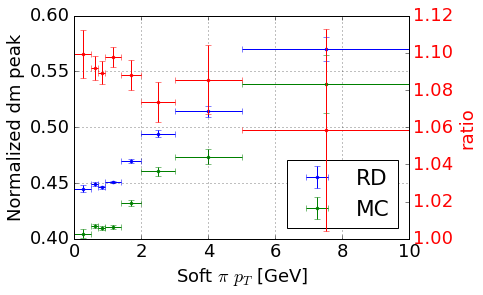

In [166]:
from histo_utilities import quantile

binsPt = np.array([0, 0.5, 0.7, 0.92, 1.4, 2, 3, 5, 10])

mRD = []
mMC = []

for m, M in zip(binsPt[:-1], binsPt[1:]):
    selRD = np.logical_and(df['pis_pt'] > m, df['pis_pt'] < M)
#     n, _ = np.histogram(dm_RD[selRD], bins=50, range=(1e3*(m_Dst-m_D0) - 2, 1e3*(m_Dst-m_D0) + 2))
#     n = np.max(n)
#     nTot = float(np.sum(selRD))
#     mRD.append([n/nTot, np.sqrt(n)/nTot])
    q15, dq15 = quantile(dm_RD[selRD], 0.15)
    q85, dq85 = quantile(dm_RD[selRD], 0.85)
    mRD.append([0.5*(q85-q15), 0.5*np.hypot(dq15, dq85)])

    selMC = np.logical_and(df_MC['pis_pt'] > m, df_MC['pis_pt'] < M)
#     n, _ = np.histogram(dm_MC[selMC], bins=50, range=(1e3*(m_Dst-m_D0) - 2, 1e3*(m_Dst-m_D0) + 2))
#     n = np.max(n)
#     nTot = float(np.sum(selMC))
#     mMC.append([n/nTot, np.sqrt(n)/nTot])
    q15, dq15 = quantile(dm_MC[selMC], 0.15)
    q85, dq85 = quantile(dm_MC[selMC], 0.85)
    mMC.append([0.5*(q85-q15), 0.5*np.hypot(dq15, dq85)])

mRD = np.array(mRD)
mMC = np.array(mMC)

r = mRD[:,0]/mMC[:,0]
dr = r*np.hypot(mMC[:,1]/mMC[:,0], mRD[:,1]/mRD[:,0])

fig, ax1 = plt.subplots()

x = (binsPt[1:] + binsPt[:-1])/2.
dx = (binsPt[1:] - binsPt[:-1])/2.

plt.errorbar(x, mRD[:,0], yerr=mRD[:,1], xerr=dx, fmt='b.', label='RD')
plt.errorbar(x, mMC[:,0], yerr=mMC[:,1], xerr=dx, fmt='g.', label='MC')

plt.legend(loc='best', numpoints=1)
plt.xlabel(r'Soft $\pi \ p_T$ [GeV]')
plt.ylabel('Normalized dm peak')
plt.grid()

ax2 = ax1.twinx()
color = 'r'
ax2.set_ylabel('ratio', color=color)
ax2.errorbar(x, r, yerr=dr, xerr=dx, fmt='r.')
ax2.tick_params(axis='y', labelcolor=color)
# ax2.grid(axis='y', color=color)

Mean pre-smearing: 145.662 +/- 0.022 MeV
Mean post-smearing: 145.626 +/- 0.023 MeV


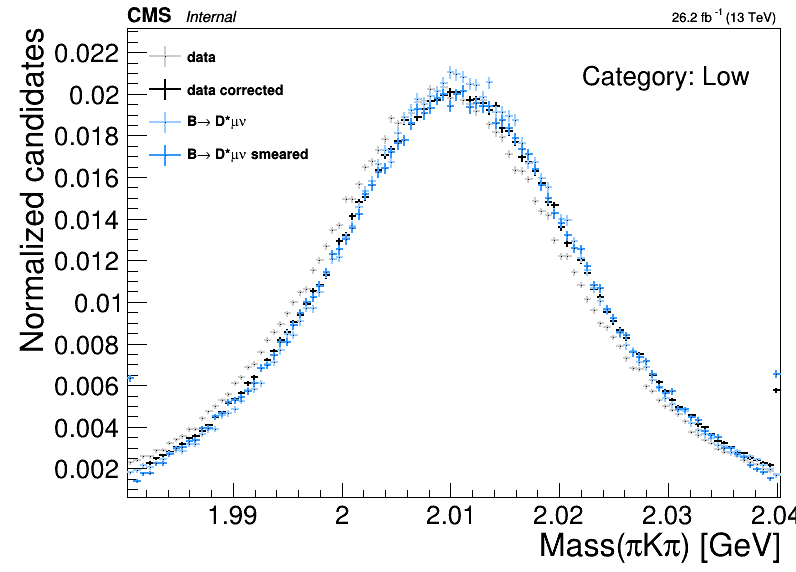

In [131]:
leg = rt.TLegend(0.18, 0.7, 0.4, 0.93)
leg.SetBorderSize(0)
leg.SetFillStyle(0)

h = create_TH1D(df['mass_D0pis'], 
                binning=[100, m_Dst-0.03, m_Dst+0.03], 
                axis_title=['Mass(#piK#pi) [GeV]', 'Normalized candidates'],
                scale_histo='norm',
                opt='overflow+underflow'
               )
h.SetLineColor(rt.kGray)
leg.AddEntry(h, 'data', 'lep')

mCorr = varMass_3(df, sp1='pi', sp2='K', sp3='pis', m1=m_pi, m2=m_K, m3=m_pi, scalePt=1+8.2e-4)
h_RD = create_TH1D(mCorr, 'corr', binning=h.binning,
                   opt='overflow+underflow',
                   scale_histo='norm')
h_RD.SetLineColor(1)
leg.AddEntry(h_RD, 'data corrected', 'lep')

a = getAvg(df_MC['mass_D0pis'])
print 'Mean pre-smearing: {:.3f} +/- {:.3f} MeV'.format(1e3*(a[0]-m_D0), a[1]*1e3)
h_MC = create_TH1D(df_MC['mass_D0pis'], 'bare', binning=h.binning,
                   opt='overflow+underflow',
                   scale_histo='norm')
h_MC.SetLineColor(rt.kAzure-9)
leg.AddEntry(h_MC, label_dic['mu'], 'lep')


mSmear = varMass_3(df_MC, sp1='pi', sp2='K', sp3='pis', m1=m_pi, m2=m_K, m3=m_pi, relSmear=3e-3)
a = getAvg(mSmear)
print 'Mean post-smearing: {:.3f} +/- {:.3f} MeV'.format(1e3*(a[0]-m_D0), a[1]*1e3)
h_MCs = create_TH1D(mSmear, 'smeared', binning=h.binning,
                   opt='overflow+underflow',
                   scale_histo='norm')
h_MCs.SetLineColor(col_dic['mu'])
leg.AddEntry(h_MCs, label_dic['mu'] + ' smeared', 'lep')

h_list = [h, h_RD, h_MC, h_MCs]

SetMaxToMaxHist(h_list)
c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
leg.Draw()
catText.DrawLatexNDC(0.95, 0.85, 'Category: Low')

In [169]:
mDstMCc, mD0MCc = varMass_3(df_MC, sp1='pi', sp2='K', sp3='pis', 
                            m1=m_pi, m2=m_K, m3=m_pi, returnM12=True, 
                            relSmear=[3e-3, 3e-3, 6e-3])

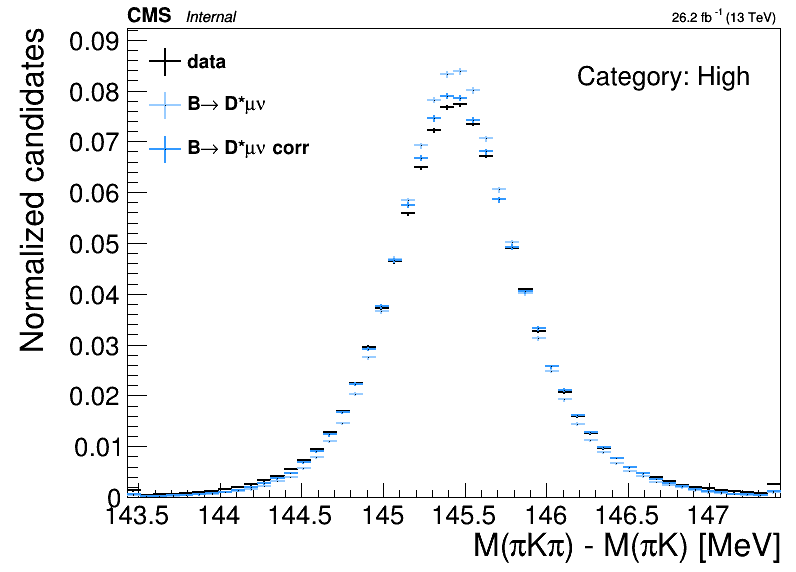

In [170]:
C = drawVar(varRD=1e3*(mDstC - mD0C),
            varMC=1e3*(mDstMC - mD0MC),
            varMCcorr=1e3*(mDstMCc - mD0MCc),
            binning=[50, 1e3*(m_Dst-m_D0) - 2, 1e3*(m_Dst-m_D0) + 2], 
            xtitle='M(#piK#pi) - M(#piK) [MeV]')

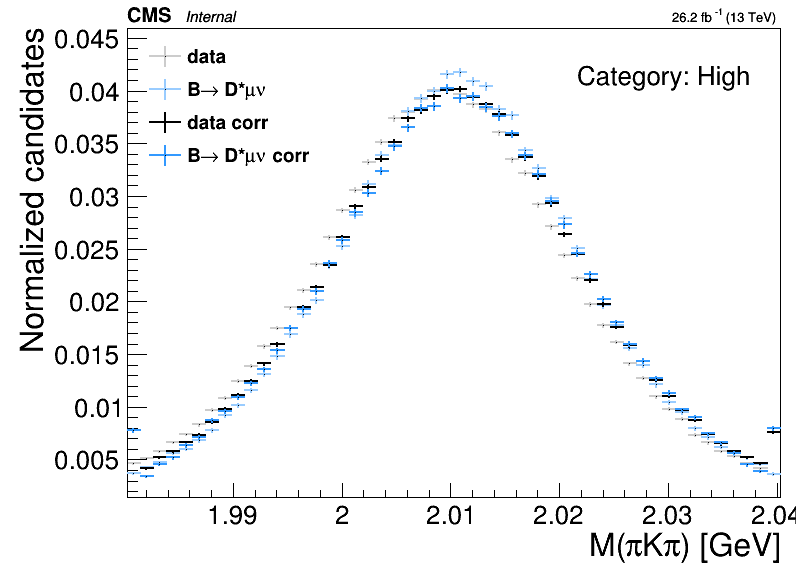

In [171]:
C = drawVar(varRD=df['mass_D0pis'], 
            varMC=df_MC['mass_D0pis'],
            varRDcorr=mDstC,
            varMCcorr=mDstMCc,
            binning=[50, m_Dst-0.03, m_Dst+0.03], 
            xtitle='M(#piK#pi) [GeV]')

# Fit

In [ ]:
def getInputs(n):
#     aeta = np.abs(df_MC[n + '_eta'])
    eta = df_MC[n + '_eta']
    pt = df_MC[n + '_pt']
    return np.column_stack((1./pt, pt, eta, pt*eta, np.square(pt), np.square(eta)))

In [ ]:
def getEventsWeights(p):
    w = p[0] + np.sum(p[1:]*getInputs('pi'), axis=1)
    w *= p[0] + np.sum(p[1:]*getInputs('K'), axis=1)
    w *= p[0] + np.sum(p[1:]*getInputs('pis'), axis=1)
    return w

In [ ]:
from scipy.optimize import minimize

In [ ]:
yd_piK, _ = np.histogram(df['mass_piK'], 100, (m_D0-0.03, m_D0+0.03))
nTot = float(np.sum(yd_piK))
ed_piK = np.sqrt(yd_piK)/nTot
yd_piK = yd_piK/nTot

def chi2_piK(w):
    ys, _ = np.histogram(df_MC['mass_piK'], 100, (m_D0-0.03, m_D0+0.03), weights=w)
    nTot = float(np.sum(ys))
    ys = ys/nTot
    
    chi2 = np.square((yd_piK - ys)/ed_piK)
    return np.sum(chi2)

In [ ]:
yd_piPt, _ = np.histogram(df['pi_pt'], 100, (0.8, 20))
nTot = float(np.sum(yd_piPt))
ed_piPt = np.sqrt(yd_piPt)/nTot
yd_piPt = yd_piPt/nTot

def chi2_piPt(w):
    ys, _ = np.histogram(df_MC['pi_pt'], 100, (0.8, 20), weights=w)
    nTot = float(np.sum(ys))
    ys = ys/nTot
    
    chi2 = np.square((yd_piPt - ys)/ed_piPt)
    return np.sum(chi2)

In [ ]:
yd_piEta, _ = np.histogram(df['pi_eta'], 100, (-2, 2))
nTot = float(np.sum(yd_piEta))
ed_piEta = np.sqrt(yd_piEta)/nTot
yd_piEta = yd_piEta/nTot

def chi2_piEta(w):
    ys, _ = np.histogram(df_MC['pi_eta'], 100, (-2, 2), weights=w)
    nTot = float(np.sum(ys))
    ys = ys/nTot
    
    chi2 = np.square((yd_piEta - ys)/ed_piEta)
    return np.sum(chi2)

In [ ]:
def fTarget(p):
    w = getEventsWeights(p)
    pen = np.sum(np.square(1-w))
    pen += np.sum(w<0)**2
    return chi2_piK(w) + chi2_piPt(w) + chi2_piEta(w) + 0.001*pen

In [ ]:
x0 = np.array([1,0,0,0,0,0,0])
print 'Start loss: {:.1f}'.format(fTarget(x0))
res = minimize(fTarget, x0, tol=1e-2)
print 'End loss: {:.1f} ({:.1f})'.format(res.fun, res.fun/100.)
print 'Optimal par:', res.x

In [ ]:
w = getEventsWeights(res.x)
plt.hist(w, bins=50, range=(np.percentile(w, 100*(1e-4)), np.percentile(w, 100*(1-1e-4))))
plt.yscale('log')

In [ ]:
C = drawVar('mass_piK', [100, m_D0-0.03, m_D0+0.03], 'M(#piK) [GeV]', weights=w)

In [ ]:
C = drawVar('pi_pt', [100, 0.8, 20], '#pi p_{T} [GeV]', weights=w)

In [ ]:
C = drawVar('pi_eta', [100, -2.2, 2.2], '#pi #eta [GeV]', weights=w)